# Rice Classification: Classifying a Grain of Rice with Neutral Physical Properties
### DSCI100: Group 124 Project Proposal


##### Sean Park (66350992)
#####
#####
#####

In [1]:
options(repr.matrix.max.rows = 6)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Introduction

#### -> About the dataset
Different types of rice are classified biologically by their origin; however, these types can also usually be identified by by their physical measurements and properties. In our dataset, "riceClassification.csv", there are more than 15,000 observations of rice grains with specified physical measurements that classify as either the rice type "**Gonen** (indicated by the factor 0)" or "**Jasmine** (indicated by the factor 1)". This data is derived from another rice observation dataset, specifically modified for efficient binary classification.

In [4]:
rice_data <- read_csv("riceClassification.csv") |>
    mutate(Class = as_factor(Class))
rice_data

Rows: 18185 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): id, Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexAr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id    Area MajorAxisLength MinorAxisLength Eccentricity ConvexArea
1     1     4537 92.22932        64.01277        0.7199162    4677      
2     2     2872 74.69188        51.40045        0.7255527    3015      
3     3     3048 76.29316        52.04349        0.7312109    3132      
⋮     ⋮     ⋮    ⋮               ⋮               ⋮            ⋮         
18183 18183 6365 154.7771        52.90808        0.9397603    6531      
18184 18184 5960 151.3979        51.47460        0.9404271    6189      
18185 18185 6134 153.0820        51.59061        0.9415000    6283      
      EquivDiameter Extent    Perimeter Roundness AspectRation Class
1     76.00452      0.6575362 273.085   0.7645096 1.440796     1    
2     60.47102      0.7130089 208.317   0.8316582 1.453137     1    
3     62.29634      0.7591532 210.012   0.8684336 1.465950     1    
⋮     ⋮             ⋮         ⋮         ⋮         ⋮            ⋮    
18183 90.02316      0.5612875 342.253   0.6828318 2.925396     0    
18184 87.11204      0.4923992 343.371   0.6352269 2.941216     0    
18185 88.37450      0.4899752 338.613   0.6722741 2.967245     0

#### -> Our objective
We will build a classifier that classifies a rice grain as either Gonen or Jasmine given its physical properties. Using this classifier, we want to predict the class of a new rice observation that we will create to be seemingly neutral; the physical properties and attributes of this new observation will be decided by taking the average for that measurement from the original dataset. 

In [5]:
new_obs <- rice_data |>
    map(cols = Area:Class, mean) |>  
                #take mean of every possible predictor variable
    as_tibble() 
                #use results as the measurements for new observation
new_obs

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


id   Area     MajorAxisLength MinorAxisLength Eccentricity ConvexArea
1 9093 7036.493 151.6808        59.80785        0.9154064    7225.818  
  EquivDiameter Extent    Perimeter Roundness AspectRation Class
1 94.13295      0.6166528 351.6069  0.7079983 2.599081     NA

Our project will be surrounding the following question: **Which class, either Gonen or Jasmine, will this "neutral" observation be classified as?**

Will our new observation, whose variables are determined as the collective averages of those in the dataset, be classified purely by chance, or is there other statistical factors that influence the prediction in the classifier and/or in the original dataset?

## Preliminary exploratory data analysis

#### This is the first row of the dataset for reference

In [6]:
slice(rice_data, 1)

id Area MajorAxisLength MinorAxisLength Eccentricity ConvexArea EquivDiameter
1 1  4537 92.22932        64.01277        0.7199162    4677       76.00452     
  Extent    Perimeter Roundness AspectRation Class
1 0.6575362 273.085   0.7645096 1.440796     1

#### This shows the mean of each column, as well as the total count of each type, and the number of rows with missing data

In [7]:
rice_summary <- rice_data %>%
    group_by(Class) %>%
    summarize(Count = n(), Missing = sum(is.na(.)), across(c(2:11), ~ mean(.x, na.rm = TRUE)))
rice_summary

Class Count Missing Area     MajorAxisLength MinorAxisLength Eccentricity
1 0     8200  0       8358.541 153.6984        69.99743        0.8887991   
2 1     9985  0       5950.785 150.0238        51.43984        0.9372571   
  ConvexArea EquivDiameter Extent    Perimeter Roundness AspectRation
1 8575.295   102.98017     0.6516059 368.9664  0.7697762 2.199598    
2 6117.584    86.86733     0.5879483 337.3508  0.6572644 2.927149

### Here are plots displaying the distributions of the various variables in the table

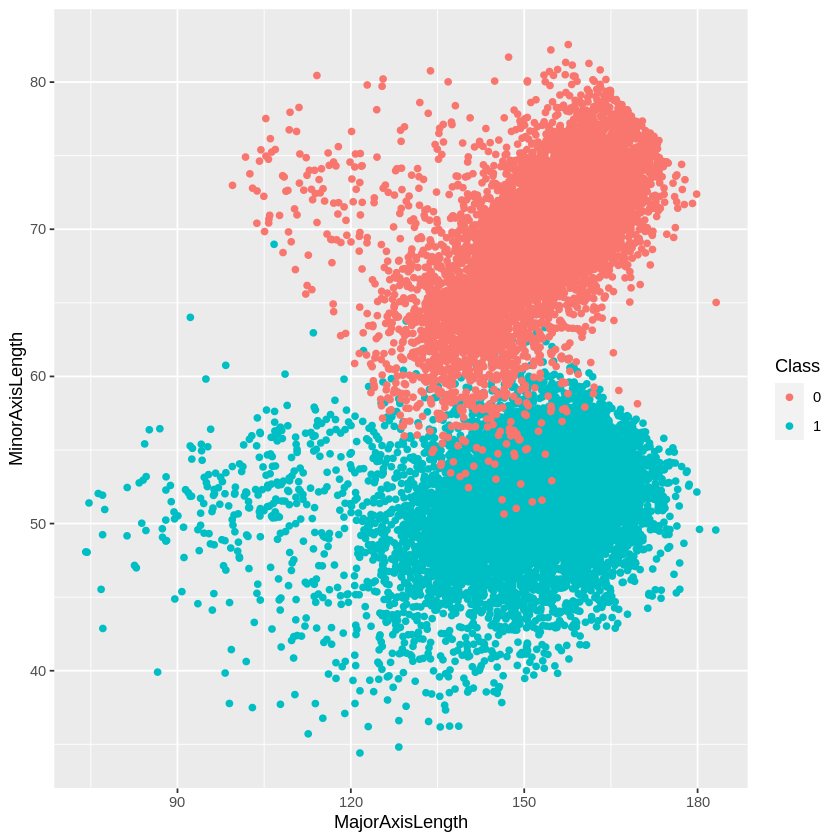

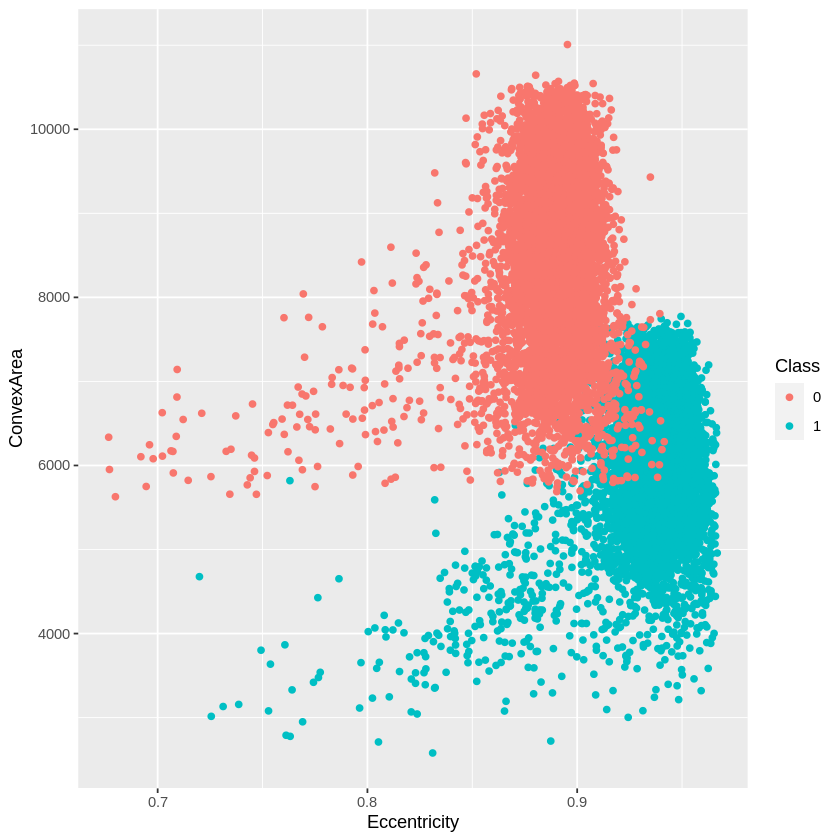

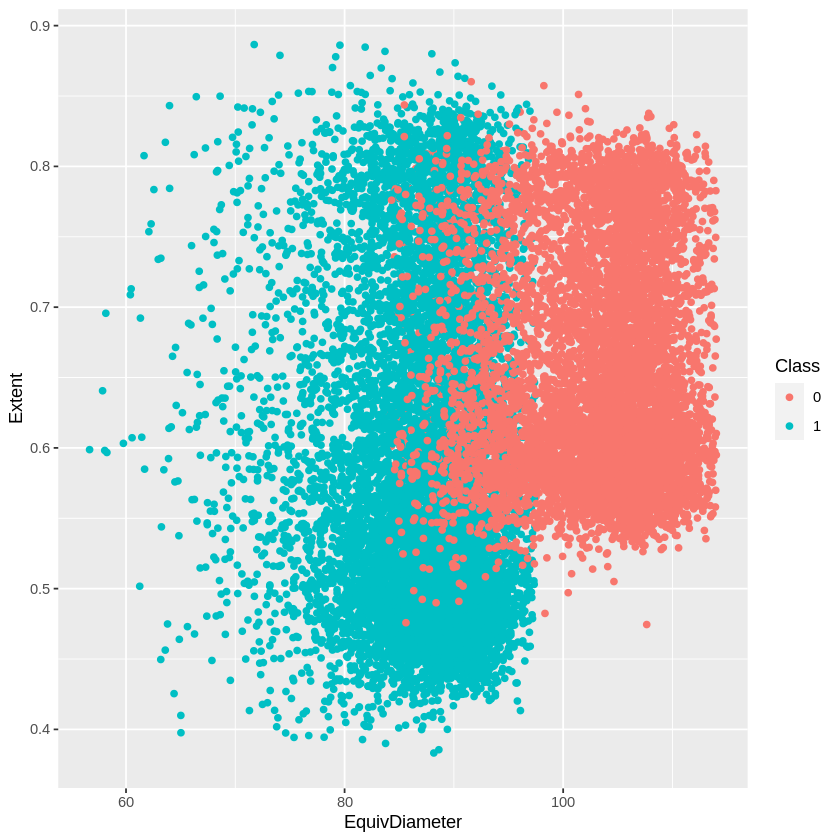

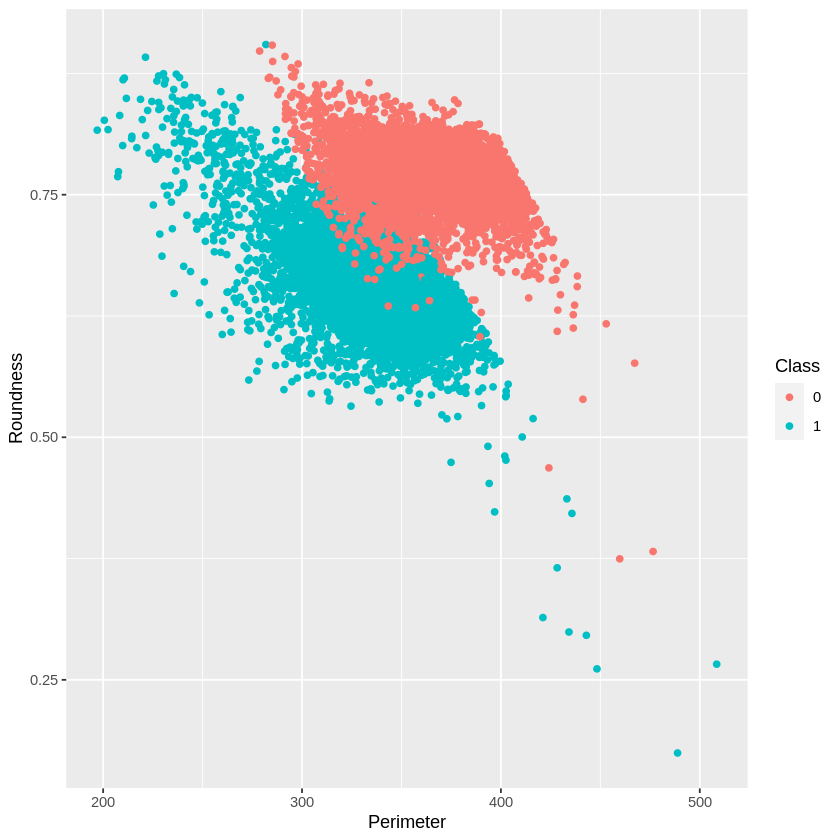

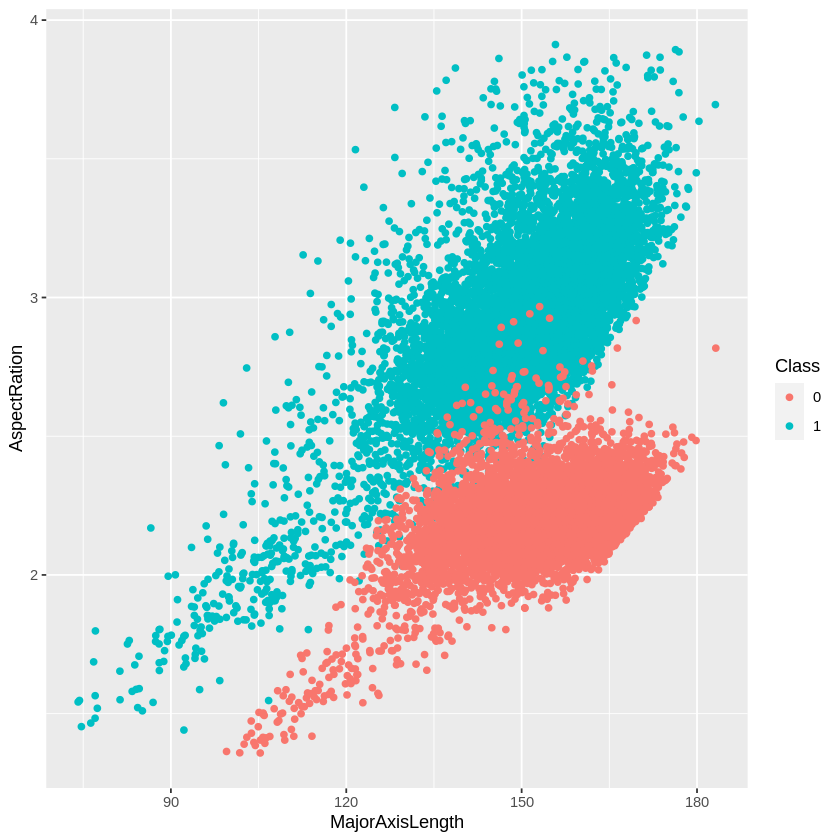

In [8]:
ggplot(rice_data, aes(x=MajorAxisLength, y = MinorAxisLength, color=Class)) +
    geom_point()
ggplot(rice_data, aes(x=Eccentricity, y = ConvexArea, color=Class)) +
    geom_point()
ggplot(rice_data, aes(x=EquivDiameter, y = Extent, color=Class)) +
    geom_point()
ggplot(rice_data, aes(x=Perimeter, y = Roundness, color=Class)) +
    geom_point()
ggplot(rice_data, aes(x=MajorAxisLength, y = AspectRation, color=Class)) +
    geom_point()

### Methods

#### -> Our plan:

##### I. Preprocessing the data + creating the new observation
As shown above, the data is already tidy to begin training our classifier. We plan to use all variables in the dataset except 'id' (unique identifier for each observation) and 'Class' (our target variable), since every variable is a distinct physical measurement that seems to have a difference in distribution among the two classes; however, in the project, we will find a way to filter any predictors, if necessary, to improve the accuracy of our classifier.

##### II. Training the classifier

Steps:

1. Split the data into a training set and testing set with a ratio of 75:25 using initial_split().

2. Filter the predictors to give our classifier

2. Split the training set for **10-fold cross validation**. ***
3. **Create a recipe** as well as a **tuning model**, ready to adjust the k parameter.
4. **Add the recipe and the tuning model** to a workflow(), and test for **50 different k parameters** using tune_grid(). ***
5. **Find the k parameter** that gives the highest accuracy in the cross-validation.
6. Using the new k parameter, **retrain the classifier** (using a new k-specific model).

# UP TO HERE ***********

7. Select which predictors we will use with the following steps:
* Test each variable as a sole predictor in the classifier (with the defined k parameter), choose the variable that gives the highest accuracy to be our first choice.
* Test each of the remaining variables to act as a predicctor along with our first choice, and choose the one that gives the highest accuracy.
* Repeat this process until adding an extra predictor does not supply a higher accuracy.

8. Redesign our classifier using the selected k value and predictors.

8. Predict the new observation using our final fit() model.

*** Since our data is large (more than 15,000 observations), we decided to cross-validate with more subsets and test for more values of k in order to create a more accurate classifier.

### Expected outcomes and significance

...